<a href="https://colab.research.google.com/github/BatoolAshour/KaustAcademy-Stage3-ExSolutions/blob/main/HorseBreedDatasetAugementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olgabelitskaya/horse-breeds")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'horse-breeds' dataset.
Path to dataset files: /kaggle/input/horse-breeds


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import kagglehub
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

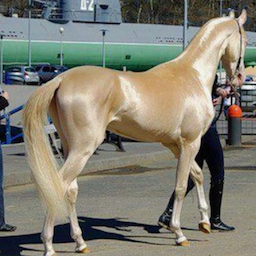

In [3]:
from PIL import Image
import os

# Load an image
image_path = os.path.join(path,"/kaggle/input/horse-breeds/01_001.png")
image = Image.open(image_path)
image

In [4]:
image_files = glob.glob(os.path.join(path, "/kaggle/input/horse-breeds", "*.png"))
print(len(image_files))
print(image_files[:5])


670
['/kaggle/input/horse-breeds/01_103.png', '/kaggle/input/horse-breeds/03_068.png', '/kaggle/input/horse-breeds/02_060.png', '/kaggle/input/horse-breeds/03_030.png', '/kaggle/input/horse-breeds/07_065.png']


In [5]:
from torchvision import transforms

# Define transformation
transform = transforms.ToTensor()

# Load and convert image
image = Image.open(image_files[0])
image_tensor = transform(image)

# Show tensor shape
print(image_tensor.shape)  # (Channels, Height, Width)

torch.Size([4, 256, 256])


In [6]:
class_names = {
    0: "Akhal-Teke",
    1: "Appaloosa",
    2: "Orlov Trotter",
    3: "Vladimir Heavy Draft",
    4: "Percheron",
    5: "Arabian",
    6: "Friesian"
}


In [7]:
# Check shape of multiple images
for image_path in image_files[:5]:  # Check first 5 images
    img = Image.open(image_path)
    print(f"Image: {image_path}, Shape: {img.size}")  # Prints (Width, Height)

Image: /kaggle/input/horse-breeds/01_103.png, Shape: (256, 256)
Image: /kaggle/input/horse-breeds/03_068.png, Shape: (256, 256)
Image: /kaggle/input/horse-breeds/02_060.png, Shape: (256, 256)
Image: /kaggle/input/horse-breeds/03_030.png, Shape: (256, 256)
Image: /kaggle/input/horse-breeds/07_065.png, Shape: (160, 160)


In [8]:
### **🔹 General Structure of a Dataset Class**
from torch.utils.data import Dataset
from PIL import Image
import glob

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None,split='train'):
        self.root_dir = root_dir  # Dataset path
        self.transform = transform  # Transformations
        self.split = split
        # Get all image paths
        self.image_paths = []
        self.labels = []
        self.image_paths = sorted(
            glob.glob(os.path.join(root_dir, "*.png"))
        )

        if len(self.image_paths) == 0:
            raise RuntimeError("No images found! Check your path.")

    def __len__(self):
        return len(self.image_paths)  # Total number of images

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        filename = os.path.basename(image_path)
        class_str = filename.split("_")[0]   # "01"
        class_id = int(class_str) - 1         # 0-based

        image = Image.open(image_path).convert("RGB")

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, class_id  # Return processed image & label

In [18]:
from torchvision import transforms

# Define transformations
transform = transforms.Compose([

    transforms.Resize((64, 64)),  # Resize all images to 64x64
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225] )
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # These random ahh values were found using ImageNet dataset, https://paperswithcode.com/dataset/imagenet
                          std=[0.229, 0.224, 0.225])
])

In [19]:
dataset = CustomDataset(
    root_dir="/kaggle/input/horse-breeds",
    transform=transform
)


print("Dataset size:", len(dataset))
img, label = dataset[0]
print("Label:", label)
print("Image size:", img.size)



Dataset size: 670
Label: 0
Image size: <built-in method size of Tensor object at 0x7fe37e44a4e0>


In [20]:
train_dataset = CustomDataset(path, split='train', transform=transform)
valid_dataset = CustomDataset(path, split='val', transform=test_transform)

In [21]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 32

# Create DataLoader
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)

# Get a batch of training images
images, labels = next(iter(train_loader))

print(f"Batch shape: {images.shape}, Labels: {labels}")

Batch shape: torch.Size([32, 3, 224, 224]), Labels: tensor([1, 6, 2, 2, 2, 5, 5, 1, 6, 0, 6, 6, 5, 2, 0, 5, 1, 6, 2, 0, 0, 6, 5, 0,
        1, 1, 1, 5, 2, 1, 6, 5])


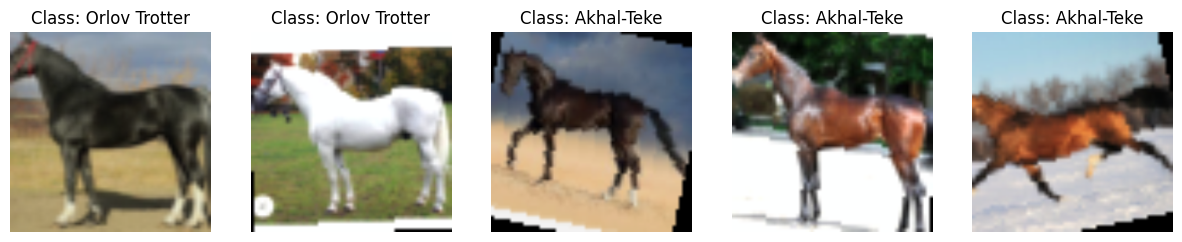

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Define mean & std for denormalization (EfficientNet Preprocessing)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Display 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

imgs_indices = [270,233,110,89,15]

for i in range(5):
    img, label = train_dataset[imgs_indices[i]]  # Load image & label

    # Convert tensor to numpy for visualization
    img_np = img.numpy().transpose(1, 2, 0)  # (C, H, W) → (H, W, C)

    # Denormalize the image
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    # Show image
    axes[i].imshow(img_np)
    axes[i].set_title(f"Class: {class_names[label]}")
    axes[i].axis('off')

plt.show()

In [23]:
from torchvision import models

# Load pretrained EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)


#model.classifier[1] = nn.Linear(model.classifier[1].in_features, 7)  # 7 classes

model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.classifier[1].in_features, 7)
)


# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)




print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)


        outputs = model(images)              # shape: [batch, 7]
        loss = criterion(outputs, labels)




        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Track accuracy
        predictions = torch.argmax(outputs, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Compute accuracy
            predictions = torch.argmax(outputs, dim=1)  # Get predicted class
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [25]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Binary Classification loss (Use when there is no softmax/sigmoid in the last layer)
optimizer = optim.AdamW(model.parameters(), lr=0.001)  # Adam optimizer
num_epochs = 10 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, valid_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")

100%|██████████| 21/21 [00:04<00:00,  4.45it/s]


Epoch 1/10: Train Loss=1.2454, Train Accuracy=57.31%, Val Loss=0.8720, Val Accuracy=71.34%


100%|██████████| 21/21 [00:04<00:00,  4.37it/s]


Epoch 2/10: Train Loss=0.6170, Train Accuracy=77.46%, Val Loss=0.8231, Val Accuracy=69.70%


100%|██████████| 21/21 [00:05<00:00,  3.78it/s]


Epoch 3/10: Train Loss=0.4051, Train Accuracy=86.12%, Val Loss=0.6614, Val Accuracy=76.87%


100%|██████████| 21/21 [00:04<00:00,  4.48it/s]


Epoch 4/10: Train Loss=0.2948, Train Accuracy=90.00%, Val Loss=0.4466, Val Accuracy=84.78%


100%|██████████| 21/21 [00:04<00:00,  4.51it/s]


Epoch 5/10: Train Loss=0.2743, Train Accuracy=91.49%, Val Loss=0.6905, Val Accuracy=76.42%


100%|██████████| 21/21 [00:05<00:00,  3.78it/s]


Epoch 6/10: Train Loss=0.2622, Train Accuracy=89.55%, Val Loss=1.4065, Val Accuracy=60.90%


100%|██████████| 21/21 [00:04<00:00,  4.21it/s]


Epoch 7/10: Train Loss=0.2291, Train Accuracy=92.39%, Val Loss=0.7028, Val Accuracy=75.67%


100%|██████████| 21/21 [00:04<00:00,  4.41it/s]


Epoch 8/10: Train Loss=0.2102, Train Accuracy=94.33%, Val Loss=0.5019, Val Accuracy=82.69%


100%|██████████| 21/21 [00:05<00:00,  3.97it/s]


Epoch 9/10: Train Loss=0.1628, Train Accuracy=94.48%, Val Loss=1.4691, Val Accuracy=57.61%


100%|██████████| 21/21 [00:05<00:00,  3.74it/s]


Epoch 10/10: Train Loss=0.1570, Train Accuracy=94.93%, Val Loss=0.5134, Val Accuracy=83.58%


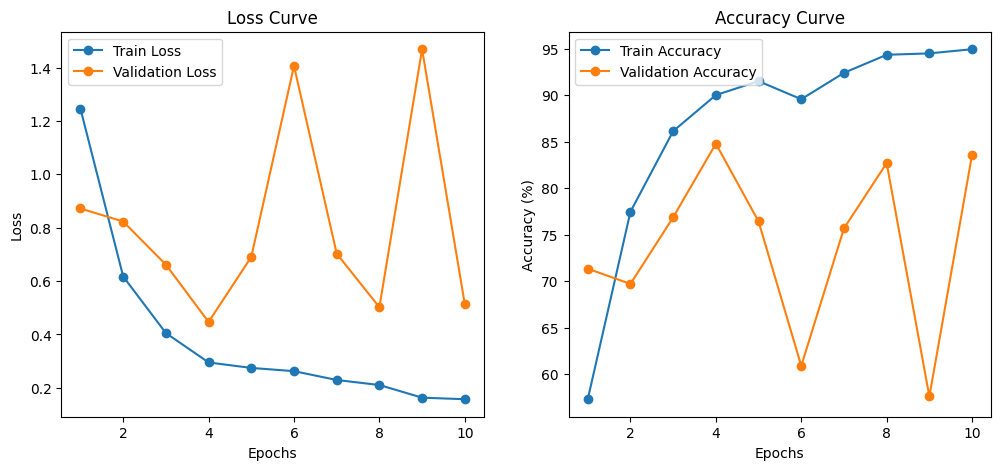

In [26]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

**The model learned the training data effectively, achieving high training accuracy (~95%). Validation accuracy improved to around 80–85%, indicating good generalization despite some fluctuations due to the small dataset size. Overall, the model shows strong performance with mild overfitting.**